In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-debator-kpa/combined_argkp.csv


In [2]:
!pip install -q protobuf==3.20.*
!pip install -q transformers==4.38.2
!pip install -q sentencepiece
!pip install -q accelerate
!pip install -q datasets
!pip install -q evaluate
!pip install transformers datasets evaluate rouge-score bert-score -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

In [3]:
# ============================================================================
# CELL 1: INSTALL AND IMPORT DEPENDENCIES
# ============================================================================

# Uncomment if running on Kaggle and packages are missing
# !pip install transformers datasets evaluate rouge-score bert-score -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer, 
    T5ForConditionalGeneration,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
import random
import warnings
from collections import Counter
import re

warnings.filterwarnings('ignore')

# Evaluation metrics
try:
    from rouge_score import rouge_scorer
    from bert_score import score as bert_score
    ROUGE_AVAILABLE = True
    BERT_SCORE_AVAILABLE = True
except:
    print("⚠️ ROUGE or BERTScore not available. Install with: pip install rouge-score bert-score")
    ROUGE_AVAILABLE = False
    BERT_SCORE_AVAILABLE = False

print("✅ All dependencies imported successfully!")


✅ All dependencies imported successfully!


In [4]:
# ============================================================================
# CELL 2: SETUP AND CONFIGURATION
# ============================================================================

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Configuration
class Config:
    MODEL_NAME = 't5-base'  # Using base model for better quality
    BATCH_SIZE = 8  # Reduced for larger model
    EPOCHS = 5  # More epochs for better learning
    LEARNING_RATE = 3e-5  # Lower learning rate for stability
    MAX_INPUT_LENGTH = 128
    MAX_TARGET_LENGTH = 256
    AUGMENTATION_RATIO = 0.9  # Better balance
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.1
    MIN_ARGUMENT_LENGTH = 50  # Filter short arguments (characters)
    MIN_WORD_COUNT = 8  # Minimum words in argument
    
config = Config()

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


🖥️  Using device: cuda
   GPU: Tesla P100-PCIE-16GB
   Memory: 17.06 GB


In [5]:
# ============================================================================
# CELL 3: DATA LOADING AND EXPLORATION
# ============================================================================

def load_and_preprocess_data(file_path):
    """
    Load CSV and extract only topic, stance, and argument columns
    Convert stance to readable format (positive/negative)
    Filter out low-quality arguments
    """
    print("📂 Loading dataset...")
    df = pd.read_csv(file_path)
    
    # Keep only required columns
    df = df[['topic', 'stance', 'argument']].copy()
    
    # Remove rows with missing values
    original_len = len(df)
    df = df.dropna()
    print(f"   Removed {original_len - len(df)} rows with missing values")
    
    # Filter out very short arguments (likely low quality)
    df = df[df['argument'].str.len() >= config.MIN_ARGUMENT_LENGTH].copy()
    df = df[df['argument'].str.split().str.len() >= config.MIN_WORD_COUNT].copy()
    print(f"   After length filter: {len(df)} samples")
    
    # Remove arguments that just repeat the topic
    def is_low_quality(row):
        topic_words = set(row['topic'].lower().split())
        arg_words = set(row['argument'].lower().split())
        overlap = len(topic_words & arg_words) / max(len(arg_words), 1)
        # If more than 70% of argument words are from topic, it's likely low quality
        if overlap > 0.7:
            return True
        
        # Filter out arguments with common filler patterns
        arg_lower = row['argument'].lower()
        
        # Remove arguments that are too generic or illogical
        bad_patterns = [
            'waste of time and money',
            'waste of money and time',
            'good thing',
            'bad thing',
            'for example',
            'etc. etc.',
            'and so on',
        ]
        
        # Count how many bad patterns appear
        pattern_count = sum(1 for pattern in bad_patterns if pattern in arg_lower)
        if pattern_count >= 2:  # If 2+ generic patterns, likely low quality
            return True
            
        return False
    
    df = df[~df.apply(is_low_quality, axis=1)].copy()
    print(f"   After quality filter: {len(df)} samples")
    print(f"   Total removed: {original_len - len(df)} low-quality arguments")
    
    # Convert stance from 1/-1 to positive/negative
    df['stance'] = df['stance'].apply(lambda x: 'positive' if x == 1 else 'negative')
    
    print(f"✅ Loaded {len(df)} high-quality samples")
    
    return df

# Load the data
df = load_and_preprocess_data('/kaggle/input/ibm-debator-kpa/combined_argkp.csv')

# Display basic statistics
print("\n📊 Dataset Statistics:")
print(f"   Total samples: {len(df)}")
print(f"   Unique topics: {df['topic'].nunique()}")
print(f"   Average argument length: {df['argument'].str.len().mean():.0f} characters")

print("\n📊 Stance Distribution:")
stance_counts = df['stance'].value_counts()
for stance, count in stance_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {stance.capitalize()}: {count} ({percentage:.1f}%)")

print("\n📊 Top 5 Topics:")
print(df['topic'].value_counts().head())

# Display sample data
print("\n📋 Sample Data:")
display(df.head())


📂 Loading dataset...
   Removed 0 rows with missing values
   After length filter: 34762 samples
   After quality filter: 34726 samples
   Total removed: 2074 low-quality arguments
✅ Loaded 34726 high-quality samples

📊 Dataset Statistics:
   Total samples: 34726
   Unique topics: 41
   Average argument length: 111 characters

📊 Stance Distribution:
   Positive: 18816 (54.2%)
   Negative: 15910 (45.8%)

📊 Top 5 Topics:
topic
We should legalize cannabis                1226
The USA is a good country to live in       1151
We should legalize sex selection           1107
The vow of celibacy should be abandoned    1056
We should ban the use of child actors      1032
Name: count, dtype: int64

📋 Sample Data:


topic    stance  \
0  Assisted suicide should be a criminal offence  negative   
1  Assisted suicide should be a criminal offence  positive   
2  Assisted suicide should be a criminal offence  positive   
3  Assisted suicide should be a criminal offence  positive   
4  Assisted suicide should be a criminal offence  positive   

                                            argument  
0  `people reach their limit when it comes to the...  
1  a cure or treatment may be discovered shortly ...  
2  a cure or treatment may be discovered shortly ...  
3  a cure or treatment may be discovered shortly ...  
4  a cure or treatment may be discovered shortly ...


🔄 Balancing dataset with data augmentation...
   Majority class (positive): 18816
   Minority class (negative): 15910
   Target minority count: 16934
   Generating 1024 augmented samples...
✅ Balanced dataset created with 35750 samples
📊 New stance distribution:
   Positive: 18816 (52.6%)
   Negative: 16934 (47.4%)


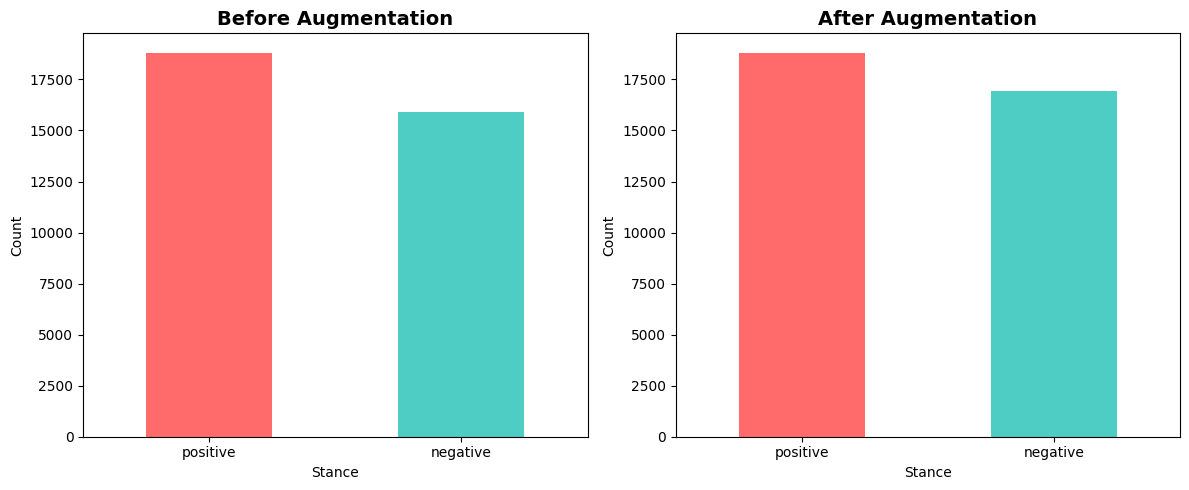

In [6]:
# ============================================================================
# CELL 5: DATA AUGMENTATION
# ============================================================================

def augment_minority_class(df, target_ratio=0.9):
    """
    Balance dataset by augmenting the minority stance class
    Uses advanced paraphrasing techniques and back-translation style augmentation
    """
    print("\n🔄 Balancing dataset with data augmentation...")
    
    # Count samples per stance
    stance_counts = df['stance'].value_counts()
    majority_class = stance_counts.idxmax()
    minority_class = stance_counts.idxmin()
    
    majority_count = stance_counts[majority_class]
    minority_count = stance_counts[minority_class]
    
    # Calculate how many samples to generate
    target_minority_count = int(majority_count * target_ratio)
    samples_to_generate = max(0, target_minority_count - minority_count)
    
    print(f"   Majority class ({majority_class}): {majority_count}")
    print(f"   Minority class ({minority_class}): {minority_count}")
    print(f"   Target minority count: {target_minority_count}")
    print(f"   Generating {samples_to_generate} augmented samples...")
    
    if samples_to_generate == 0:
        print("   ✅ Dataset already balanced!")
        return df
    
    # Get minority class samples
    minority_df = df[df['stance'] == minority_class].copy()
    
    # More sophisticated augmentation patterns
    def augment_text(text):
        """Apply multiple augmentation techniques"""
        
        # Pattern 1: Synonym replacement
        synonyms = {
            'should': ['must', 'ought to', 'needs to'],
            'can': ['could', 'may', 'might'],
            'people': ['individuals', 'persons', 'citizens'],
            'because': ['since', 'as', 'due to the fact that'],
            'many': ['numerous', 'several', 'a lot of'],
            'important': ['crucial', 'essential', 'vital', 'significant'],
            'good': ['beneficial', 'positive', 'advantageous'],
            'bad': ['harmful', 'negative', 'detrimental', 'adverse'],
            'make': ['create', 'produce', 'generate'],
            'use': ['utilize', 'employ', 'apply'],
            'help': ['assist', 'aid', 'support'],
            'need': ['require', 'necessitate'],
            'want': ['desire', 'wish', 'seek'],
            'think': ['believe', 'consider', 'feel'],
            'know': ['understand', 'recognize', 'realize'],
            'get': ['obtain', 'acquire', 'receive'],
            'give': ['provide', 'offer', 'supply'],
        }
        
        words = text.split()
        for i, word in enumerate(words):
            word_lower = word.lower().strip('.,!?;:')
            if word_lower in synonyms and random.random() < 0.3:  # 30% chance
                replacement = random.choice(synonyms[word_lower])
                # Preserve capitalization
                if word[0].isupper():
                    replacement = replacement.capitalize()
                words[i] = word.replace(word_lower, replacement)
        
        augmented = ' '.join(words)
        
        # Pattern 2: Sentence restructuring (simple reordering)
        if 'because' in augmented.lower() and random.random() < 0.3:
            parts = augmented.split(' because ')
            if len(parts) == 2:
                augmented = f"Because {parts[1].strip()}, {parts[0].lower().strip()}"
        
        return augmented
    
    augmented_samples = []
    
    # Generate augmented samples with variety
    for i in range(samples_to_generate):
        # Select a sample from minority class (cycle through)
        sample = minority_df.iloc[i % len(minority_df)].copy()
        
        # Apply augmentation 1-2 times
        augmented_text = sample['argument']
        for _ in range(random.randint(1, 2)):
            augmented_text = augment_text(augmented_text)
        
        sample['argument'] = augmented_text
        augmented_samples.append(sample)
    
    # Create augmented dataframe
    augmented_df = pd.DataFrame(augmented_samples)
    
    # Combine original and augmented data
    balanced_df = pd.concat([df, augmented_df], ignore_index=True)
    
    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✅ Balanced dataset created with {len(balanced_df)} samples")
    print(f"📊 New stance distribution:")
    new_counts = balanced_df['stance'].value_counts()
    for stance, count in new_counts.items():
        percentage = (count / len(balanced_df)) * 100
        print(f"   {stance.capitalize()}: {count} ({percentage:.1f}%)")
    
    return balanced_df

# Apply data augmentation
balanced_df = augment_minority_class(df, target_ratio=config.AUGMENTATION_RATIO)

# Visualize before/after augmentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before augmentation
df['stance'].value_counts().plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Before Augmentation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Stance')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# After augmentation
balanced_df['stance'].value_counts().plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
ax2.set_title('After Augmentation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Stance')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [7]:
# ============================================================================
# CELL 6: TRAIN/VAL/TEST SPLIT
# ============================================================================

print("\n✂️  Splitting dataset into train/val/test sets...")

# First split: separate test set
train_val_df, test_df = train_test_split(
    balanced_df,
    test_size=config.TEST_SPLIT,
    random_state=42,
    stratify=balanced_df['stance']
)

# Second split: separate train and validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=config.VAL_SPLIT / (1 - config.TEST_SPLIT),  # Adjust for already removed test set
    random_state=42,
    stratify=train_val_df['stance']
)

print(f"   Training samples: {len(train_df)} ({len(train_df)/len(balanced_df)*100:.1f}%)")
print(f"   Validation samples: {len(val_df)} ({len(val_df)/len(balanced_df)*100:.1f}%)")
print(f"   Test samples: {len(test_df)} ({len(test_df)/len(balanced_df)*100:.1f}%)")

print("\n📊 Stance distribution across splits:")
for name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    counts = split_df['stance'].value_counts()
    print(f"   {name}: Positive={counts.get('positive', 0)}, Negative={counts.get('negative', 0)}")



✂️  Splitting dataset into train/val/test sets...
   Training samples: 26812 (75.0%)
   Validation samples: 5363 (15.0%)
   Test samples: 3575 (10.0%)

📊 Stance distribution across splits:
   Train: Positive=14111, Negative=12701
   Val: Positive=2823, Negative=2540
   Test: Positive=1882, Negative=1693


In [8]:
# ============================================================================
# CELL 7: DATASET CLASS
# ============================================================================

class ArgumentDataset(Dataset):
    """
    Custom Dataset for argument generation
    Input format: "generate argument: topic: [TOPIC] | stance: [STANCE]"
    Output format: "[ARGUMENT]"
    """
    def __init__(self, dataframe, tokenizer, max_input_length=128, max_target_length=256):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Create input text with stronger stance conditioning
        stance_instruction = "support" if row['stance'] == 'positive' else "oppose"
        input_text = f"Task: {stance_instruction} the following position with a logical argument. Topic: {row['topic']} | Generate argument:"
        target_text = row['argument']
        
        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenize target
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Get input_ids and attention_mask, remove batch dimension
        input_ids = input_encoding['input_ids'].squeeze()
        attention_mask = input_encoding['attention_mask'].squeeze()
        labels = target_encoding['input_ids'].squeeze()
        
        # Replace padding token ids in labels with -100 (ignored by loss function)
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

print("✅ Dataset class defined successfully!")


✅ Dataset class defined successfully!


In [9]:
# ============================================================================
# CELL 8: INITIALIZE MODEL AND TOKENIZER
# ============================================================================

print("\n🤖 Loading model and tokenizer...")
tokenizer = T5Tokenizer.from_pretrained(config.MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(config.MODEL_NAME)
model.to(device)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model loaded: {config.MODEL_NAME}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")



🤖 Loading model and tokenizer...


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Model loaded: t5-base
   Total parameters: 222,903,552
   Trainable parameters: 222,903,552


In [10]:
# ============================================================================
# CELL 9: CREATE DATALOADERS
# ============================================================================

print("\n📦 Creating datasets and dataloaders...")

train_dataset = ArgumentDataset(train_df, tokenizer, config.MAX_INPUT_LENGTH, config.MAX_TARGET_LENGTH)
val_dataset = ArgumentDataset(val_df, tokenizer, config.MAX_INPUT_LENGTH, config.MAX_TARGET_LENGTH)
test_dataset = ArgumentDataset(test_df, tokenizer, config.MAX_INPUT_LENGTH, config.MAX_TARGET_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE)

print(f"✅ Dataloaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")



📦 Creating datasets and dataloaders...
✅ Dataloaders created:
   Train batches: 3352
   Val batches: 671
   Test batches: 447


In [11]:
# ============================================================================
# CELL 10: TRAINING FUNCTION
# ============================================================================

def train_model(model, train_loader, val_loader, device, epochs=3, learning_rate=5e-5):
    """
    Train the T5 model on argument generation task
    Uses AdamW optimizer with linear warmup schedule
    Tracks and returns training history
    """
    print(f"\n🚀 Starting training on {device}...")
    
    # Optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler with warmup
    total_steps = len(train_loader) * epochs
    warmup_steps = int(0.1 * total_steps)  # 10% warmup
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Track history
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': []
    }
    
    # Training loop
    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"📚 Epoch {epoch + 1}/{epochs}")
        print(f"{'='*60}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc="Training")
        
        for batch in train_pbar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            train_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc="Validation")
        
        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                val_loss += outputs.loss.item()
                val_pbar.set_postfix({'loss': f'{outputs.loss.item():.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['learning_rate'].append(scheduler.get_last_lr()[0])
        
        # Print epoch summary
        print(f"\n📊 Epoch {epoch + 1} Summary:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Val Loss: {avg_val_loss:.4f}")
        print(f"   Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    
    print(f"\n{'='*60}")
    print("🎉 Training completed!")
    print(f"{'='*60}")
    
    return model, history



🚀 Starting training on cuda...

📚 Epoch 1/5


Training:   0%|          | 0/3352 [00:00<?, ?it/s]

Validation:   0%|          | 0/671 [00:00<?, ?it/s]


📊 Epoch 1 Summary:
   Train Loss: 2.8585
   Val Loss: 2.4069
   Learning Rate: 2.67e-05

📚 Epoch 2/5


Training:   0%|          | 0/3352 [00:00<?, ?it/s]

Validation:   0%|          | 0/671 [00:00<?, ?it/s]


📊 Epoch 2 Summary:
   Train Loss: 2.4697
   Val Loss: 2.2124
   Learning Rate: 2.00e-05

📚 Epoch 3/5


Training:   0%|          | 0/3352 [00:00<?, ?it/s]

Validation:   0%|          | 0/671 [00:00<?, ?it/s]


📊 Epoch 3 Summary:
   Train Loss: 2.3143
   Val Loss: 2.0962
   Learning Rate: 1.33e-05

📚 Epoch 4/5


Training:   0%|          | 0/3352 [00:00<?, ?it/s]

Validation:   0%|          | 0/671 [00:00<?, ?it/s]


📊 Epoch 4 Summary:
   Train Loss: 2.2197
   Val Loss: 2.0285
   Learning Rate: 6.67e-06

📚 Epoch 5/5


Training:   0%|          | 0/3352 [00:00<?, ?it/s]

Validation:   0%|          | 0/671 [00:00<?, ?it/s]


📊 Epoch 5 Summary:
   Train Loss: 2.1696
   Val Loss: 2.0056
   Learning Rate: 0.00e+00

🎉 Training completed!


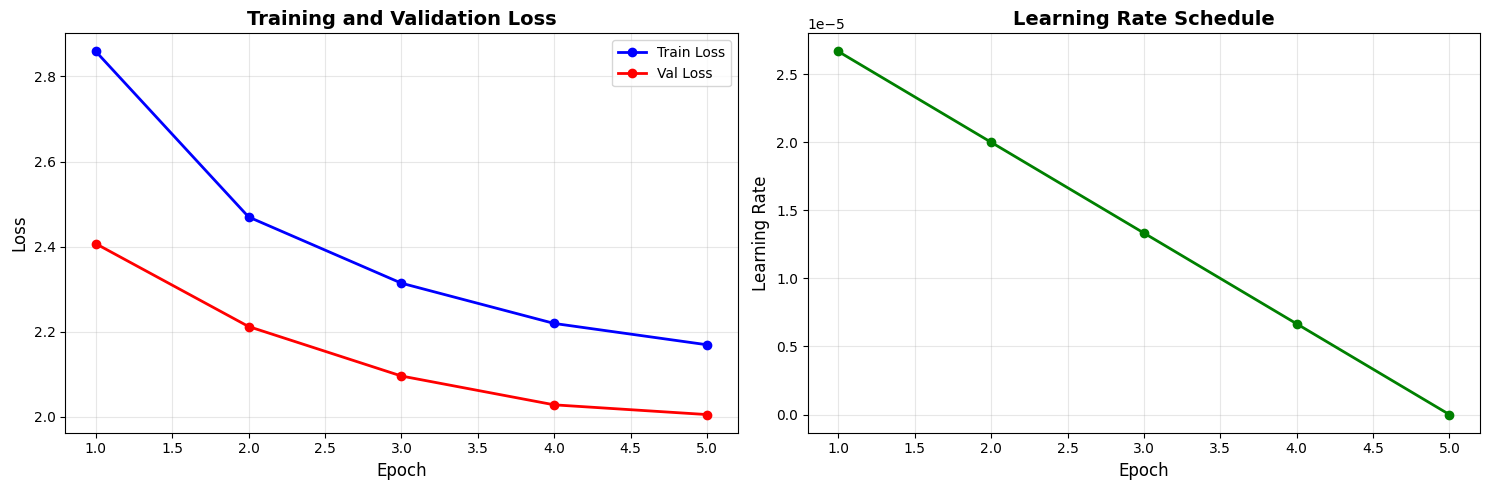

In [12]:
# ============================================================================
# CELL 11: TRAIN THE MODEL
# ============================================================================

model, history = train_model(
    model, 
    train_loader, 
    val_loader, 
    device, 
    epochs=config.EPOCHS,
    learning_rate=config.LEARNING_RATE
)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
epochs_range = range(1, config.EPOCHS + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Learning rate
ax2.plot(epochs_range, history['learning_rate'], 'g-o', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

In [13]:
# ============================================================================
# CELL 12: INFERENCE FUNCTION
# ============================================================================

def generate_argument(model, tokenizer, topic, stance, device, max_length=256, num_beams=8, temperature=0.85):
    """
    Generate an argument for a given topic and stance with improved parameters
    
    Args:
        model: Fine-tuned T5 model
        tokenizer: T5 tokenizer
        topic: Topic string
        stance: 'positive' or 'negative'
        device: torch device
        max_length: Maximum length of generated text
        num_beams: Number of beams for beam search (higher = better quality)
        temperature: Sampling temperature (lower = more focused)
    
    Returns:
        Generated argument text
    """
    model.eval()
    
    # Create input text - matching training format with stronger stance conditioning
    stance_instruction = "support" if stance == 'positive' else "oppose"
    input_text = f"Task: {stance_instruction} the following position with a logical argument. Topic: {topic} | Generate argument:"
    
    # Tokenize
    input_ids = tokenizer(
        input_text,
        return_tensors='pt',
        max_length=config.MAX_INPUT_LENGTH,
        truncation=True
    ).input_ids.to(device)
    
    # Generate with improved parameters for coherence
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            min_length=35,  # Minimum length for substance
            num_beams=num_beams,  # More beams for better quality
            temperature=temperature,  # Lower temperature for more coherent output
            top_k=40,  # Reduced top-k for better focus
            top_p=0.92,  # Slightly lower nucleus sampling
            do_sample=True,  # Enable sampling for diversity
            early_stopping=True,
            no_repeat_ngram_size=4,  # Prevent 4-gram repetition (stricter)
            length_penalty=1.5,  # Stronger encouragement for longer outputs
            repetition_penalty=2.0,  # Very strong repetition penalty
            encoder_repetition_penalty=1.5,  # Also penalize input repetition
        )
    
    # Decode
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return generated_text

print("✅ Inference function defined!")

✅ Inference function defined!


In [14]:
# ============================================================================
# CELL 13: EVALUATION METRICS
# ============================================================================

class ArgumentEvaluator:
    """Comprehensive evaluation metrics for generated arguments"""
    
    def __init__(self):
        if ROUGE_AVAILABLE:
            self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    def calculate_rouge(self, reference, generated):
        """Calculate ROUGE scores"""
        if not ROUGE_AVAILABLE:
            return None
        scores = self.rouge_scorer.score(reference, generated)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }
    
    def calculate_bert_score(self, references, generated_list):
        """Calculate BERTScore (batch processing for efficiency)"""
        if not BERT_SCORE_AVAILABLE:
            return None
        P, R, F1 = bert_score(generated_list, references, lang='en', verbose=False)
        return {
            'precision': P.mean().item(),
            'recall': R.mean().item(),
            'f1': F1.mean().item()
        }
    
    def calculate_diversity(self, generated_text):
        """Calculate lexical diversity metrics"""
        words = generated_text.lower().split()
        if len(words) == 0:
            return 0.0
        unique_words = set(words)
        return len(unique_words) / len(words)
    
    def calculate_length_similarity(self, reference, generated):
        """Calculate how similar the lengths are"""
        ref_len = len(reference.split())
        gen_len = len(generated.split())
        return 1 - abs(ref_len - gen_len) / max(ref_len, gen_len)
    
    def check_creativity(self, reference, generated):
        """
        Check if generated text is creative (not just copying reference)
        Returns similarity score (lower = more creative)
        """
        ref_words = set(reference.lower().split())
        gen_words = set(generated.lower().split())
        
        if len(gen_words) == 0:
            return 0.0
        
        # Calculate word overlap
        overlap = len(ref_words & gen_words) / len(gen_words)
        return 1 - overlap  # Return creativity score (higher = more creative)
    
    def evaluate_test_set(self, model, tokenizer, test_df, device, sample_size=None):
        """Evaluate model on test set with comprehensive metrics"""
        print("\n📊 Evaluating model on test set...")
        
        if sample_size:
            test_sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=42)
        else:
            test_sample = test_df
        
        results = []
        references = []
        generated_list = []
        
        for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample), desc="Evaluating"):
            # Generate argument
            generated = generate_argument(
                model, tokenizer, row['topic'], row['stance'], device
            )
            
            reference = row['argument']
            
            # Calculate metrics
            rouge_scores = self.calculate_rouge(reference, generated)
            diversity = self.calculate_diversity(generated)
            length_sim = self.calculate_length_similarity(reference, generated)
            creativity = self.check_creativity(reference, generated)
            
            results.append({
                'topic': row['topic'],
                'stance': row['stance'],
                'reference': reference,
                'generated': generated,
                'rouge1': rouge_scores['rouge1'] if rouge_scores else None,
                'rouge2': rouge_scores['rouge2'] if rouge_scores else None,
                'rougeL': rouge_scores['rougeL'] if rouge_scores else None,
                'diversity': diversity,
                'length_similarity': length_sim,
                'creativity': creativity
            })
            
            references.append(reference)
            generated_list.append(generated)
        
        # Calculate BERTScore for all samples at once (more efficient)
        if BERT_SCORE_AVAILABLE:
            bert_scores = self.calculate_bert_score(references, generated_list)
            print(f"\n📈 BERTScore (Overall):")
            print(f"   Precision: {bert_scores['precision']:.4f}")
            print(f"   Recall: {bert_scores['recall']:.4f}")
            print(f"   F1: {bert_scores['f1']:.4f}")
        
        results_df = pd.DataFrame(results)
        
        # Print summary statistics
        print(f"\n📈 Evaluation Metrics Summary:")
        if ROUGE_AVAILABLE:
            print(f"   ROUGE-1: {results_df['rouge1'].mean():.4f} ± {results_df['rouge1'].std():.4f}")
            print(f"   ROUGE-2: {results_df['rouge2'].mean():.4f} ± {results_df['rouge2'].std():.4f}")
            print(f"   ROUGE-L: {results_df['rougeL'].mean():.4f} ± {results_df['rougeL'].std():.4f}")
        print(f"   Diversity: {results_df['diversity'].mean():.4f} ± {results_df['diversity'].std():.4f}")
        print(f"   Length Similarity: {results_df['length_similarity'].mean():.4f} ± {results_df['length_similarity'].std():.4f}")
        print(f"   Creativity Score: {results_df['creativity'].mean():.4f} ± {results_df['creativity'].std():.4f}")
        
        return results_df

evaluator = ArgumentEvaluator()
print("✅ Evaluator initialized!")


✅ Evaluator initialized!


In [15]:
# ============================================================================
# CELL 14: RUN TEST SET EVALUATION
# ============================================================================

# Evaluate on test set (use sample_size=50 for faster evaluation)
test_results = evaluator.evaluate_test_set(
    model, 
    tokenizer, 
    test_df, 
    device,
    sample_size=100  # Adjust based on your needs
)

# Display sample results
print("\n📋 Sample Evaluation Results:")
display(test_results[['topic', 'stance', 'reference', 'generated', 'rouge1', 'diversity', 'creativity']].head(10))



📊 Evaluating model on test set...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📈 BERTScore (Overall):
   Precision: 0.8745
   Recall: 0.8849
   F1: 0.8796

📈 Evaluation Metrics Summary:
   ROUGE-1: 0.2740 ± 0.0900
   ROUGE-2: 0.0656 ± 0.0565
   ROUGE-L: 0.1995 ± 0.0668
   Diversity: 0.8859 ± 0.0546
   Length Similarity: 0.6121 ± 0.1967
   Creativity Score: 0.7837 ± 0.0847

📋 Sample Evaluation Results:


topic    stance  \
0  Social media platforms should be regulated by ...  negative   
1                     We should end racial profiling  positive   
2                            We should adopt atheism  negative   
3                     Homeschooling should be banned  negative   
4              We should subsidize space exploration  positive   
5                     We should ban cosmetic surgery  negative   
6                    We should prohibit flag burning  negative   
7                     We should end racial profiling  positive   
8                        We should legalize cannabis  positive   
9              We should introduce compulsory voting  positive   

                                           reference  \
0  People should be able to express themselves fr...   
1  racial profiling does no one any good. it shou...   
2  People should be allowed to choose how to beli...   
3  absolutely wrong to ban homeschooling because ...   
4  we should subsidize space exploration for rese...   
5  we should not ban cosmetic surgery because peo...   
6  burning the flag is freedom of speech and it w...   
7  racial profiling has been used to target minor...   
8  law enforcement are unable to effectively prev...   
9  everyone should be required to vote to make su...   

                                           generated    rouge1  diversity  \
0  Social media platforms should not be regulated...  0.291667   0.851852   
1  racial profiling is discriminatory and should ...  0.324324   0.961538   
2  we should not adopt atheism because it is a fo...  0.447761   0.896552   
3  homeschooling should not be banned because it ...  0.274510   0.861111   
4  space exploration should be subsidized because...  0.400000   1.000000   
5  cosmetic surgery can help people who have a se...  0.307692   0.967742   
6  flag burning is a free speech right and should...  0.423077   0.800000   
7  racial profiling is discriminatory and should ...  0.347826   0.964286   
8  we should legalize cannabis because it is a na...  0.318841   0.974359   
9  compulsory voting would ensure that all voters...  0.307692   0.818182   

   creativity  
0    0.695652  
1    0.760000  
2    0.615385  
3    0.838710  
4    0.766667  
5    0.733333  
6    0.642857  
7    0.703704  
8    0.736842  
9    0.777778

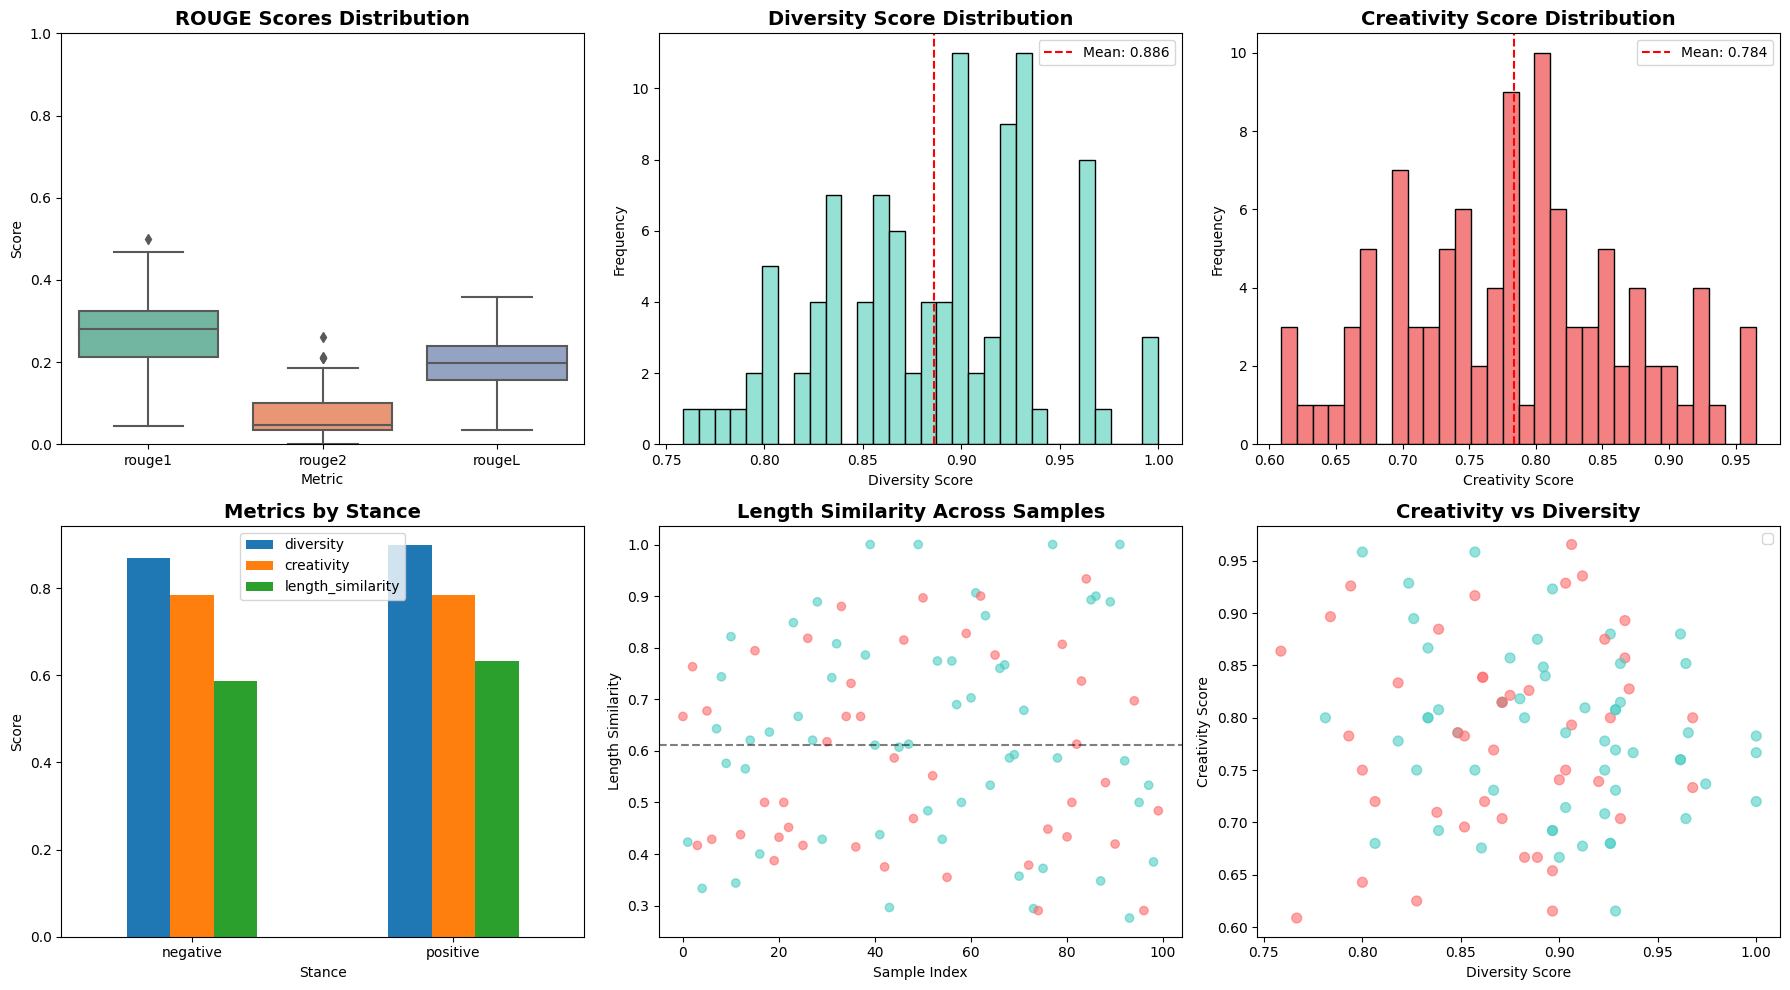

In [16]:
# ============================================================================
# CELL 4: DATA VISUALIZATION
# ============================================================================

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. ROUGE Scores Distribution
if ROUGE_AVAILABLE:
    rouge_data = test_results[['rouge1', 'rouge2', 'rougeL']].melt(var_name='Metric', value_name='Score')
    sns.boxplot(data=rouge_data, x='Metric', y='Score', ax=axes[0, 0], palette='Set2')
    axes[0, 0].set_title('ROUGE Scores Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylim(0, 1)

# 2. Diversity Score Distribution
axes[0, 1].hist(test_results['diversity'], bins=30, color='#95E1D3', edgecolor='black')
axes[0, 1].set_title('Diversity Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Diversity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(test_results['diversity'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {test_results["diversity"].mean():.3f}')
axes[0, 1].legend()

# 3. Creativity Score Distribution
axes[0, 2].hist(test_results['creativity'], bins=30, color='#F38181', edgecolor='black')
axes[0, 2].set_title('Creativity Score Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Creativity Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(test_results['creativity'].mean(), color='red', linestyle='--',
                    label=f'Mean: {test_results["creativity"].mean():.3f}')
axes[0, 2].legend()

# 4. Metrics by Stance
stance_metrics = test_results.groupby('stance')[['diversity', 'creativity', 'length_similarity']].mean()
stance_metrics.plot(kind='bar', ax=axes[1, 0], rot=0)
axes[1, 0].set_title('Metrics by Stance', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Stance')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend(loc='best')

# 5. Length Similarity
axes[1, 1].scatter(test_results.index, test_results['length_similarity'], 
                   c=test_results['stance'].map({'positive': '#4ECDC4', 'negative': '#FF6B6B'}),
                   alpha=0.6)
axes[1, 1].set_title('Length Similarity Across Samples', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Length Similarity')
axes[1, 1].axhline(test_results['length_similarity'].mean(), color='black', linestyle='--', alpha=0.5)

# 6. Creativity vs Diversity Scatter
scatter = axes[1, 2].scatter(test_results['diversity'], test_results['creativity'],
                             c=test_results['stance'].map({'positive': '#4ECDC4', 'negative': '#FF6B6B'}),
                             alpha=0.6, s=50)
axes[1, 2].set_title('Creativity vs Diversity', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Diversity Score')
axes[1, 2].set_ylabel('Creativity Score')
axes[1, 2].legend(handles=scatter.legend_elements()[0], labels=['Negative', 'Positive'])

plt.tight_layout()
plt.show()

In [17]:
# ============================================================================
# CELL 16: QUALITATIVE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("📝 QUALITATIVE ANALYSIS - Sample Generated Arguments")
print("="*80)

# Show best performing samples (high creativity and diversity)
test_results['combined_score'] = (test_results['creativity'] + test_results['diversity']) / 2
best_samples = test_results.nlargest(5, 'combined_score')

print("\n🌟 Top 5 Most Creative & Diverse Arguments:\n")
for idx, row in best_samples.iterrows():
    print(f"{'─'*80}")
    print(f"Topic: {row['topic']}")
    print(f"Stance: {row['stance'].upper()}")
    print(f"\n📖 Reference:")
    print(f"   {row['reference']}")
    print(f"\n✨ Generated:")
    print(f"   {row['generated']}")
    print(f"\n📊 Scores:")
    print(f"   Creativity: {row['creativity']:.3f} | Diversity: {row['diversity']:.3f} | ROUGE-1: {row['rouge1']:.3f}")
    print()

# Show samples that need improvement (low scores)
worst_samples = test_results.nsmallest(3, 'combined_score')

print(f"\n{'='*80}")
print("⚠️  Samples Needing Improvement:\n")
for idx, row in worst_samples.iterrows():
    print(f"{'─'*80}")
    print(f"Topic: {row['topic']}")
    print(f"Stance: {row['stance'].upper()}")
    print(f"\n📖 Reference:")
    print(f"   {row['reference']}")
    print(f"\n⚠️  Generated:")
    print(f"   {row['generated']}")
    print(f"\n📊 Scores:")
    print(f"   Creativity: {row['creativity']:.3f} | Diversity: {row['diversity']:.3f} | ROUGE-1: {row['rouge1']:.3f}")
    print()


📝 QUALITATIVE ANALYSIS - Sample Generated Arguments

🌟 Top 5 Most Creative & Diverse Arguments:

────────────────────────────────────────────────────────────────────────────────
Topic: We should ban the use of child actors
Stance: NEGATIVE

📖 Reference:
   movies and shows without children in them would feel incomplete and unrealistic.

✨ Generated:
   we should not ban the use of child actors because it is important for them to be able to make their own decisions about what they want to do with their lives.

📊 Scores:
   Creativity: 0.966 | Diversity: 0.906 | ROUGE-1: 0.045

────────────────────────────────────────────────────────────────────────────────
Topic: We should subsidize journalism
Stance: NEGATIVE

📖 Reference:
   subsidizing journalism lowers the barrier to entry and can allow more fake news and junk reporting to proliferate so to speak

✨ Generated:
   we should not subsidize journalism because it is a waste of money that would be better spent on other things such as edu

In [18]:
# ============================================================================
# CELL 17: TEST ON NEW TOPICS
# ============================================================================

print("\n" + "="*80)
print("🧪 TESTING ON NEW UNSEEN TOPICS")
print("="*80)

test_topics = [
    "Nuclear energy should be expanded",
    "Social media does more harm than good",
    "Universal basic income should be implemented",
    "Space exploration is worth the cost",
    "Genetic engineering of humans should be allowed",
    "Remote work should become the standard",
    "Cryptocurrencies should replace traditional currency",
    "Artificial intelligence poses an existential threat",
    "College education should be free for all",
    "Meat consumption should be banned",
    "Surveillance is necessary for public safety",
    "Climate change is the most pressing issue",
    "Immigration policies should be more lenient",
    "Death penalty should be abolished",
    "Homework should be banned in schools"
]

new_topic_results = []

print("\n🔮 Generating arguments for new topics...\n")

for topic in test_topics:
    print(f"{'─'*80}")
    print(f"📌 Topic: {topic}")
    
    for stance in ['positive', 'negative']:
        argument = generate_argument(model, tokenizer, topic, stance, device)
        
        # Calculate diversity for this generation
        diversity = evaluator.calculate_diversity(argument)
        
        new_topic_results.append({
            'topic': topic,
            'stance': stance,
            'generated_argument': argument,
            'diversity': diversity,
            'length': len(argument.split())
        })
        
        print(f"\n   {stance.upper()} stance:")
        print(f"   {argument}")
        print(f"   [Diversity: {diversity:.3f}, Length: {len(argument.split())} words]")
    
    print()

# Convert to DataFrame
new_results_df = pd.DataFrame(new_topic_results)

print(f"\n{'='*80}")
print("✅ Generated arguments for all new topics!")
print(f"{'='*80}")



🧪 TESTING ON NEW UNSEEN TOPICS

🔮 Generating arguments for new topics...

────────────────────────────────────────────────────────────────────────────────
📌 Topic: Nuclear energy should be expanded

   POSITIVE stance:
   nuclear energy should be expanded because it is a renewable resource that can be used for many other purposes, such as agriculture and food production. there is no need to limit the use of nuclear energy.
   [Diversity: 0.917, Length: 36 words]

   NEGATIVE stance:
   nuclear energy is a waste of resources and should not be expanded. there is no need to increase the amount of nuclear waste that can be used for other purposes such as heating water or cooking food.
   [Diversity: 0.865, Length: 37 words]

────────────────────────────────────────────────────────────────────────────────
📌 Topic: Social media does more harm than good

   POSITIVE stance:
   Social media does more harm than good because it encourages people to post things that they don't want to retweet or


📊 Analysis of New Topic Generations:

Average Diversity: 0.8873
Average Length: 32.8 words

By Stance:
          diversity     length
stance                        
negative   0.900515  32.666667
positive   0.874013  33.000000


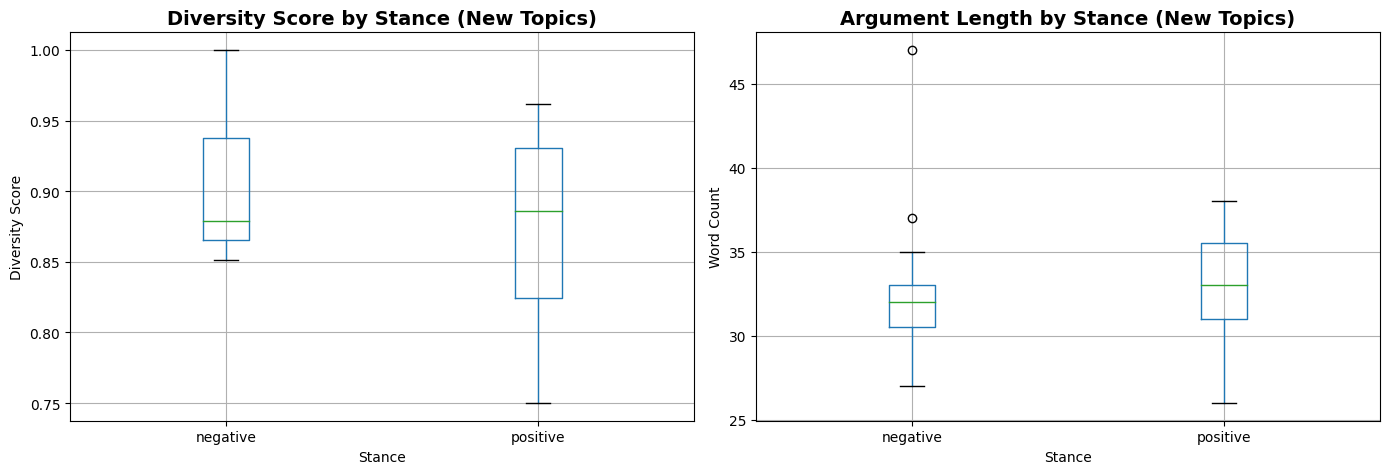

In [19]:
# ============================================================================
# CELL 18: ANALYZE NEW TOPIC RESULTS
# ============================================================================

print("\n📊 Analysis of New Topic Generations:\n")
print(f"Average Diversity: {new_results_df['diversity'].mean():.4f}")
print(f"Average Length: {new_results_df['length'].mean():.1f} words")
print(f"\nBy Stance:")
print(new_results_df.groupby('stance')[['diversity', 'length']].mean())

# Visualize new topic results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Diversity by stance
new_results_df.boxplot(column='diversity', by='stance', ax=axes[0])
axes[0].set_title('Diversity Score by Stance (New Topics)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stance')
axes[0].set_ylabel('Diversity Score')
plt.suptitle('')

# Length by stance
new_results_df.boxplot(column='length', by='stance', ax=axes[1])
axes[1].set_title('Argument Length by Stance (New Topics)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stance')
axes[1].set_ylabel('Word Count')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [20]:
# ============================================================================
# CELL 19: SAVE RESULTS TO CSV
# ============================================================================

print("\n💾 Saving results to CSV files...")

# Save test set evaluation results
test_results.to_csv('test_set_evaluation.csv', index=False)
print(f"✅ Test set evaluation saved to: test_set_evaluation.csv")

# Save new topic generation results
new_results_df.to_csv('generated_arguments_new_topics.csv', index=False)
print(f"✅ New topic generations saved to: generated_arguments_new_topics.csv")

# Create a summary report
summary_df = pd.DataFrame({
    'Metric': ['Train Loss (Final)', 'Val Loss (Final)', 
               'Avg ROUGE-1', 'Avg ROUGE-2', 'Avg ROUGE-L',
               'Avg Diversity', 'Avg Creativity', 'Avg Length Similarity'],
    'Value': [
        history['train_loss'][-1],
        history['val_loss'][-1],
        test_results['rouge1'].mean() if ROUGE_AVAILABLE else 'N/A',
        test_results['rouge2'].mean() if ROUGE_AVAILABLE else 'N/A',
        test_results['rougeL'].mean() if ROUGE_AVAILABLE else 'N/A',
        test_results['diversity'].mean(),
        test_results['creativity'].mean(),
        test_results['length_similarity'].mean()
    ]
})

summary_df.to_csv('evaluation_summary.csv', index=False)
print(f"✅ Evaluation summary saved to: evaluation_summary.csv")

print("\n" + "="*80)
print("📋 EVALUATION SUMMARY")
print("="*80)
display(summary_df)


💾 Saving results to CSV files...
✅ Test set evaluation saved to: test_set_evaluation.csv
✅ New topic generations saved to: generated_arguments_new_topics.csv
✅ Evaluation summary saved to: evaluation_summary.csv

📋 EVALUATION SUMMARY


Metric     Value
0     Train Loss (Final)  2.169585
1       Val Loss (Final)  2.005616
2            Avg ROUGE-1  0.273987
3            Avg ROUGE-2  0.065607
4            Avg ROUGE-L  0.199495
5          Avg Diversity  0.885864
6         Avg Creativity  0.783749
7  Avg Length Similarity  0.612062

In [21]:
# ============================================================================
# CELL 20: SAVE MODEL
# ============================================================================

print("\n💾 Saving trained model...")

model_save_path = './argument_generator_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model and tokenizer saved to: {model_save_path}")

# Save training configuration
config_dict = {
    'model_name': config.MODEL_NAME,
    'epochs': config.EPOCHS,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'max_input_length': config.MAX_INPUT_LENGTH,
    'max_target_length': config.MAX_TARGET_LENGTH,
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1]
}

config_df = pd.DataFrame([config_dict])
config_df.to_csv('training_config.csv', index=False)
print(f"✅ Training configuration saved to: training_config.csv")

print("\n" + "="*80)
print("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("\n📁 Generated Files:")
print("   1. test_set_evaluation.csv - Detailed evaluation on test set")
print("   2. generated_arguments_new_topics.csv - Arguments for 15 new topics")
print("   3. evaluation_summary.csv - Overall metrics summary")
print("   4. training_config.csv - Training configuration and final losses")
print("   5. ./argument_generator_model/ - Saved model and tokenizer")
print("\n✨ Your model is ready to generate creative arguments!")



💾 Saving trained model...
✅ Model and tokenizer saved to: ./argument_generator_model
✅ Training configuration saved to: training_config.csv

🎉 PIPELINE COMPLETED SUCCESSFULLY!

📁 Generated Files:
   1. test_set_evaluation.csv - Detailed evaluation on test set
   2. generated_arguments_new_topics.csv - Arguments for 15 new topics
   3. evaluation_summary.csv - Overall metrics summary
   4. training_config.csv - Training configuration and final losses
   5. ./argument_generator_model/ - Saved model and tokenizer

✨ Your model is ready to generate creative arguments!


In [22]:
# # ============================================================================
# # CELL 21: INTERACTIVE TESTING (OPTIONAL)
# # ============================================================================

# print("\n" + "="*80)
# print("🎮 INTERACTIVE TESTING")
# print("="*80)
# print("\nYou can now test the model with custom topics!")
# print("Example usage:\n")
# print("topic = 'Your custom topic here'")
# print("stance = 'positive'  # or 'negative'")
# print("argument = generate_argument(model, tokenizer, topic, stance, device)")
# print("print(argument)")

# # Example interactive test
# def test_custom_topic(topic, stance):
#     """Helper function for quick testing"""
#     print(f"\n{'─'*60}")
#     print(f"Topic: {topic}")
#     print(f"Stance: {stance.upper()}")
#     print(f"{'─'*60}")
    
#     argument = generate_argument(model, tokenizer, topic, stance, device)
#     diversity = evaluator.calculate_diversity(argument)
    
#     print(f"\nGenerated Argument:")
#     print(f"{argument}")
#     print(f"\n📊 Diversity Score: {diversity:.3f}")
#     print(f"📏 Length: {len(argument.split())} words")
    
#     return argument

# # Example test
# print("\n🔍 Example Test:")
# test_custom_topic("Video games should be considered a sport", "positive")2, 2, figsize=(15, 10))

# # 1. Stance distribution
# stance_counts.plot(kind='bar', ax=axes[0, 0], color=['#FF6B6B', '#4ECDC4'])
# axes[0, 0].set_title('Stance Distribution', fontsize=14, fontweight='bold')
# axes[0, 0].set_xlabel('Stance')
# axes[0, 0].set_ylabel('Count')
# axes[0, 0].tick_params(axis='x', rotation=0)

# # 2. Argument length distribution
# df['arg_length'] = df['argument'].str.len()
# axes[0, 1].hist(df['arg_length'], bins=50, color='#95E1D3', edgecolor='black')
# axes[0, 1].set_title('Argument Length Distribution', fontsize=14, fontweight='bold')
# axes[0, 1].set_xlabel('Character Count')
# axes[0, 1].set_ylabel('Frequency')
# axes[0, 1].axvline(df['arg_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["arg_length"].mean():.0f}')
# axes[0, 1].legend()

# # 3. Top 10 topics
# top_topics = df['topic'].value_counts().head(10)
# axes[1, 0].barh(range(len(top_topics)), top_topics.values, color='#F38181')
# axes[1, 0].set_yticks(range(len(top_topics)))
# axes[1, 0].set_yticklabels([topic[:40] + '...' if len(topic) > 40 else topic for topic in top_topics.index])
# axes[1, 0].set_title('Top 10 Topics', fontsize=14, fontweight='bold')
# axes[1, 0].set_xlabel('Count')
# axes[1, 0].invert_yaxis()

# # 4. Stance by argument length
# df.boxplot(column='arg_length', by='stance', ax=axes[1, 1])
# axes[1, 1].set_title('Argument Length by Stance', fontsize=14, fontweight='bold')
# axes[1, 1].set_xlabel('Stance')
# axes[1, 1].set_ylabel('Character Count')
# plt.suptitle('')  # Remove automatic title

# plt.tight_layout()
# plt.show()
